In [39]:
from helpermodules.memory_handling import PickleHelper
from models.lstm import prepare_lstm_data, train_lstm, evaluate_model
import pandas as pd
import os
import numpy as np
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [40]:

df = PickleHelper.pickle_load("final_dataframe")

In [41]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler

def prepare_lstm_data(df, input_sequence_length=60, batch_size=32, split_fraction=0.7):
    """
    Prepare data for an LSTM model using stock_1 and correlation as features,
    and stock_2 as the target.

    Args:
        df (DataFrame): Input DataFrame with columns ['AdjClose_Stock_1', 'AdjClose_Stock_2', 'Rolling_Correlation_Coefficient'].
        input_sequence_length (int): Number of past time steps to use as input.
        batch_size (int): Batch size for the TimeseriesGenerator.
        split_fraction (float): Fraction of data to use for training.

    Returns:
        train_dataset (TimeseriesGenerator): Training data generator.
        test_dataset (TimeseriesGenerator): Testing data generator.
        scaler_features (StandardScaler): Scaler used for normalizing the input features.
        scaler_target (StandardScaler): Scaler used for normalizing the target values.
    """
    # Ensure required columns are present in the DataFrame
    required_columns = ['AdjClose_Stock_1', 'AdjClose_Stock_2', 'Rolling_Correlation_Coefficient']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Extract the columns
    stock_1 = df['AdjClose_Stock_1'].values.reshape(-1, 1)
    stock_2 = df['AdjClose_Stock_2'].values.reshape(-1, 1)  # Target variable
    correlation = df['Rolling_Correlation_Coefficient'].values.reshape(-1, 1)

    # Normalize the features (stock_1 and correlation) and the target (stock_2)
    scaler_features = StandardScaler()
    scaler_target = StandardScaler()

    # Stack features (stock_1 and correlation) together and normalize
    features = np.hstack([stock_1, correlation])
    normalized_features = scaler_features.fit_transform(features)

    # Normalize the target (stock_2)
    normalized_target = scaler_target.fit_transform(stock_2)

    # Split the data into training and test sets
    num_samples = len(df)
    train_size = int(split_fraction * num_samples)

    # Create TimeseriesGenerator instances for train and test sets
    train_dataset = TimeseriesGenerator(
        data=normalized_features[:train_size],
        targets=normalized_target[:train_size],
        length=input_sequence_length,
        batch_size=batch_size,
    )

    test_dataset = TimeseriesGenerator(
        data=normalized_features[train_size:],
        targets=normalized_target[train_size:],
        length=input_sequence_length,
        batch_size=batch_size,
    )

    return train_dataset, test_dataset, scaler_features, scaler_target


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def lstm_model(train_dataset, scaler):
    """
    Builds, trains, and prepares an LSTM model using the training data.

    Parameters:
        train_dataset: TimeseriesGenerator providing the input and target data.
        scaler: StandardScaler used for normalizing the target data.

    Returns:
        model (Sequential): Trained LSTM model.
        inverse_transform_predictions (function): Function to inverse transform predictions.
    """
    # Infer input shape from the TimeseriesGenerator
    input_shape = train_dataset[0][0].shape[1:]  # (sequence_length, number_of_features)

    # Build the LSTM model
    model = Sequential()
    # 1st Layer
    model.add(LSTM(units=32, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))  # Dropout to avoid overfitting
    # 2nd Layer
    model.add(LSTM(units=32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))

    # Output Layer
    model.add(Dense(units=1))  # Single output value

    # Compile the model with a lower learning rate
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='loss',  # Monitor training loss
        patience=3,  # Stop training after 3 epochs with no improvement
        restore_best_weights=True  # Restore the best weights after stopping
    )

    # Train the model using the TimeseriesGenerator
    model.fit(train_dataset, epochs=50, callbacks=[early_stopping], verbose=1)

    # Define a helper function for inverse transformation
    def inverse_transform_predictions(predictions):
        return scaler.inverse_transform(predictions.reshape(-1, 1))

    return model, inverse_transform_predictions


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_and_plot(model, test_dataset, inverse_transform, scaler_target):
    """
    Make predictions, compute metrics, and plot the predicted vs. actual values.
    
    Parameters:
        model: Trained LSTM model.
        test_dataset: TimeseriesGenerator providing the test data.
        inverse_transform: Function to inverse-transform predictions.
        scaler_target: StandardScaler used for normalizing the target data.
        
    Returns:
        None
    """
    # Get the true target values and model predictions
    actuals = []
    predictions = []
    
    for i in range(len(test_dataset)):
        x_batch, y_batch = test_dataset[i]
        pred_batch = model.predict(x_batch, verbose=0)
        predictions.append(pred_batch)
        actuals.append(y_batch)
    
    # Concatenate all batches
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)

    # Inverse transform to get values back to the original scale
    predictions_original = inverse_transform(predictions)
    actuals_original = scaler_target.inverse_transform(actuals)

    # Compute metrics
    mse = mean_squared_error(actuals_original, predictions_original)
    mae = mean_absolute_error(actuals_original, predictions_original)
    r2 = r2_score(actuals_original, predictions_original)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-Squared (R²): {r2:.4f}")

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(actuals_original, label="Actual Stock 2 Prices", color='blue')
    plt.plot(predictions_original, label="Predicted Stock 2 Prices", color='orange', linestyle='dashed')
    plt.title("Actual vs Predicted Stock 2 Prices")
    plt.xlabel("Time Steps")
    plt.ylabel("Stock 2 Price")
    plt.legend()
    plt.show()


In [44]:
# Step 1: Prepare Data
train_dataset, test_dataset, scaler_features, scaler_target = prepare_lstm_data(
    df, input_sequence_length=60, batch_size=32, split_fraction=0.7
)



In [45]:
# Step 2: Build and Train Model
model, inverse_transform = lstm_model(train_dataset, scaler_target)


c:\Users\giuli\Repositories\nasdaq_causal-analysis_lstm\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\giuli\Repositories\nasdaq_causal-analysis_lstm\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - loss: 2.7396
Epoch 2/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - loss: 1.0922
Epoch 3/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - loss: 0.4547
Epoch 4/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - loss: 0.2219
Epoch 5/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - loss: 0.1277
Epoch 6/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - loss: 0.1513
Epoch 7/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - loss: 0.0905
Epoch 8/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 0.0548
Epoch 9/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - loss: 0.0483
Epoch 10/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 29s 77ms/step - loss: 0.0559
Epoch 11/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 39s 104ms/step - loss: 0.0473
Epoch 12/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - loss: 0.0410
Epoch 13/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 0.0384
Epoch 14/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 0.0334
Epoch 15/50
380/380 ━━━━━━━━

In [47]:
import pickle
from tensorflow.keras.models import Sequential

# Save the model using pickle
def save_model_with_pickle(model, filename):
    # Serialize the model architecture and weights separately
    model_json = model.to_json()  # Convert model architecture to JSON
    model_weights = model.get_weights()  # Get model weights

    # Save the model architecture and weights to a pickle file
    with open(filename, 'wb') as f:
        pickle.dump({'model_json': model_json, 'model_weights': model_weights}, f)

# Example usage:
save_model_with_pickle(model, 'lstm_model.pkl')


Mean Squared Error (MSE): 3.6189
Mean Absolute Error (MAE): 0.9746
R-Squared (R²): 0.9526


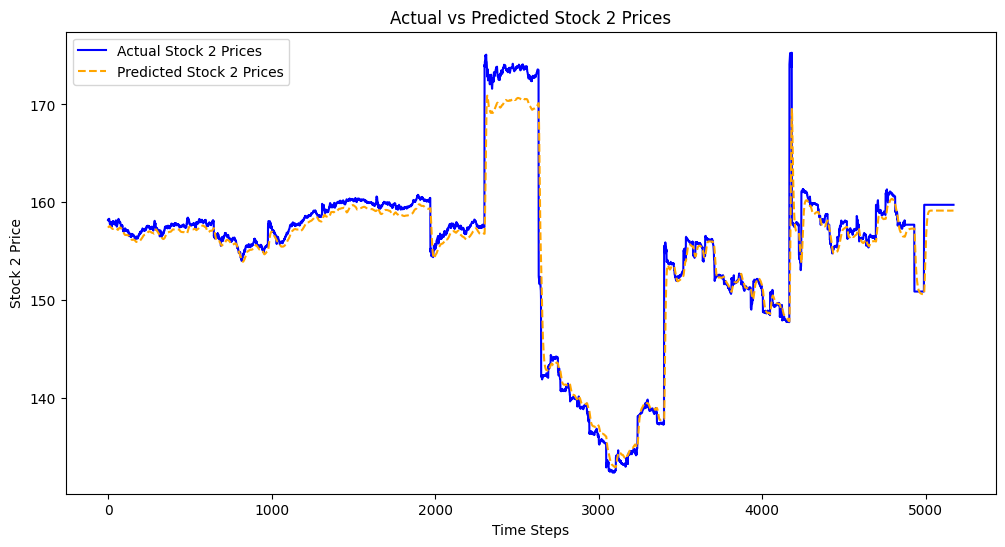

In [52]:

# Step 3: Evaluate and Plot
evaluate_and_plot(model, test_dataset, inverse_transform, scaler_target)